## Industrial Machine Fault Detection using Deep Learning
### Machines: Pumps, motors, valves etc. 

### Training a MLP on MFCC features generated from equipment sound files

Rajesh Siraskar | 22-May-2021
- V.2.0: Add predict
- V.2.1: Add seaborn plots with error bands

- Load data
- Split into train/test
- Build MLP network architecture
- Compile network
- Train network

In [3]:
import json
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

### Load data

In [4]:
JSON_FILE = "audio_files/valve_features.json"
NUMBER_OF_CLASSES = 2 # Valve normal/abnormal
TRAIN_EPOCHS = 200

In [5]:
def load_data (json_file):
    with open(json_file, "r") as fp:
        data = json.load(fp)
        
        # Note: mfcc was converted from a numpy array to list before storing in JSON
        #  Need convert back to numpy array
        X = np.array(data["mfcc"])
        y = np.array(data["labels"])
        
    return X, y

In [4]:
def plot_history (history, regularization_flag=False):

    #sns.set_theme(style="darkgrid")
    # Plot the responses for different events and regions
    #sns.lineplot(x="timepoint", y="signal", hue="region", style
  
    fig, axs = plt.subplots(2, figsize=(12, 8)) # width, height
            
    # Accuracy sub-plot
    axs[0].plot(history.history["acc"], label="Training accuracy")
    axs[0].plot(history.history["val_acc"], label="Test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_facecolor('#FFFFF0') # little darker biege: #F5F5DC
    if regularization_flag: axs[0].set_title("Accuracy plot (with regularizatiton)")
    else: axs[0].set_title("Accuracy plot")
    
    # Error (loss) sub-plot
    axs[1].plot(history.history["loss"], label="Training error")
    axs[1].plot(history.history["val_loss"], label="Test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epochs")   
    axs[1].legend(loc="upper right")
    axs[1].set_facecolor('#FFFFF0')
    if regularization_flag: axs[1].set_title("Error plot (with regularizatiton)")
    else: axs[1].set_title("Error plot")
    
    plt.show()

### Main function
- Network: 
    - 1 input  = Flatten 3-D numpy array and use only 2-Ds (mfcc and hop-length)
    - 3 hidden = 512 x 256 x 64. Activation = ReLU
    - 1 output = Number of classes (genres). 4 genres. Activation = softmax  
- Mini-batch
- Adam optimization
- Learning-rate=0.0001

In [5]:
### 1. Load data
X, y = load_data (json_file = JSON_FILE)


### 2. Split into train/test
X_train, X_test, y_train, y_test = train_test_split (X, y, test_size=0.3)

### 3. Build MLP network architecture
#     i/p, 3 hidden, o/p and all fully-connected (i.e. dense)
model = keras.Sequential([
    # Input layer: 
    #   input json is a 3D file: We ignore 1st dim and consider only 2nd and 3rd dims
    #   MFCC for each segment, and each mfcc is a vector over an interval = hop-length
    #   - dimension 1: num_segments x n_classes x .wav-files-per-class 
    #   - dimension 2: num_mfcc_vectors_per_segment = math.ceil(samples_per_segment/hop_length)
    #   - dimension 3: num_mfcc
    #   X.shape[1] = dim-2 and X.shape[2]=dim-2
    #   first-dim: interval = inputs.shape[1]
    #   second-dim: mfcc = inputs.shape[2]
    #   NOTE: inputs.shape[0] is the segment number and we are not passing that
    keras.layers.Flatten(input_shape=(X.shape[1], X.shape[2])),
    
    # 1st hidden-layer:
    #   Use ReLU instead of sigmoid. Much faster.
    #   ReLU better convergence. Reduce likelihood of vanishing gradients
    #   Vanishing gradients: Multiply error by derivative of activation fn.
    #   Sigmoid fn. derivative = 0.25. Keep multiplying by 0.25, gradient becomes smaller and smaller
    #   and *vanishes*
    keras.layers.Dense(512, activation="relu"),
    
    # 2nd hidden-layer:
    keras.layers.Dense(256, activation="relu"),
    
    # 3rd hidden-layer:
    keras.layers.Dense(64, activation="relu"),
    
    # Output layer: NUMBER_OF_CLASSES = number of genres = 4
    #   activation fn. = softmax for normalizing prob. sum to 1.0 and enables us to pick max. prob.
    keras.layers.Dense(NUMBER_OF_CLASSES,  activation="softmax")
])


### 4. Compile network
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, 
             loss="sparse_categorical_crossentropy",
             metrics=["accuracy"])

model.summary()

## 5. Train network. 
#     Use min-batch. Other techniques
#     (1) Stochastic = Gradient on one sample, fast, inaccurate. 
#     (2) Full training set: Very accurate 
#     (3) Mini-batch: in-between

history = model.fit(X_train, y_train,                 # Training data
                    validation_data=(X_test, y_test), # Test data
                    epochs=TRAIN_EPOCHS,
                    batch_size=32) 

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 1080)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               553472    
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 130       
Total params: 701,378
Trainable params: 701,378
Non-trainable params: 0
________________________________________________________________

67/67 [==============================] - 0s 239us/sample - loss: 2.7935e-04 - acc: 1.0000 - val_loss: 5.8998 - val_acc: 0.5862
Epoch 108/200
67/67 [==============================] - 0s 239us/sample - loss: 2.7120e-04 - acc: 1.0000 - val_loss: 5.8812 - val_acc: 0.5862
Epoch 109/200
67/67 [==============================] - 0s 239us/sample - loss: 2.6283e-04 - acc: 1.0000 - val_loss: 5.8368 - val_acc: 0.5862
Epoch 110/200
67/67 [==============================] - 0s 239us/sample - loss: 2.4928e-04 - acc: 1.0000 - val_loss: 5.7702 - val_acc: 0.5862
Epoch 111/200
67/67 [==============================] - 0s 238us/sample - loss: 2.3814e-04 - acc: 1.0000 - val_loss: 5.7161 - val_acc: 0.5862
Epoch 112/200
67/67 [==============================] - 0s 239us/sample - loss: 2.4870e-04 - acc: 1.0000 - val_loss: 5.7005 - val_acc: 0.5862
Epoch 113/200
67/67 [==============================] - 0s 239us/sample - loss: 2.4212e-04 - acc: 1.0000 - val_loss: 5.7327 - val_acc: 0.5862
Epoch 114/200
67/67 [======

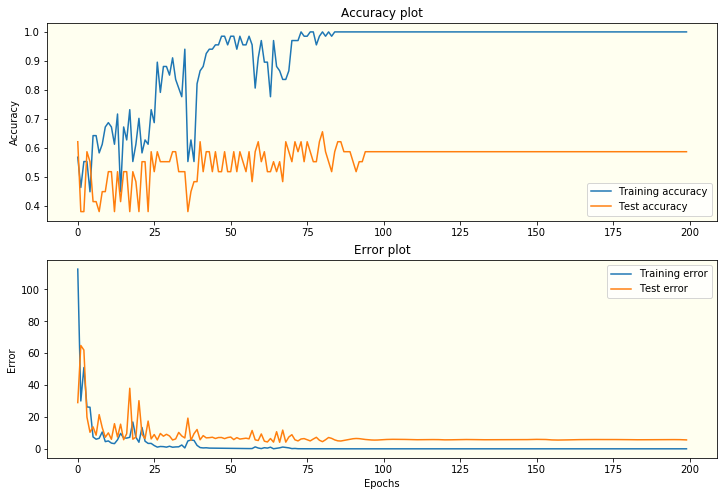

In [6]:
## 6. Plot training curves - NO regularization
plot_history(history, regularization_flag=False)

### Reducing Over-fitting
- 5 techniques
    - Simpler architecture
    - Data-augmentation: Pitch change, Time-stretching, Add noise
    - Early stopping
    - Drop-out
    - Regularization    

- **Drop-out**: NN can't depend on any particular neuron and tries to spread out weights and makes ot robust
- **Regularization**: 
    - Add penalty to error function
    - Punish large weigths
    - L1: Minimize absolute values of weights: $E(p, y) = \frac{1}{2} (p-y)^2 + \lambda \sum |W_i|$
    - L2: Minimize _squared_ values of weights: $E(p, y) = \frac{1}{2} (p-y)^2 + \lambda \sum |W_i|^2$
    - L1: Robust to outliers, simpler model
    - L2: NOT robust to outliers, learns complex patterns

In [7]:
### 1. Load data
X, y = load_data (json_file = JSON_FILE)


### 2. Split into train/test
X_train, X_test, y_train, y_test = train_test_split (X, y, test_size=0.3)

### 3. Build MLP network architecture
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(X.shape[1], X.shape[2])),
    
    # Hidden-layers: With added Dropout amd Regularization with Lambda=0.001
    # 1st hidden-layer:
    keras.layers.Dense(512, activation="relu", kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dropout(0.3),
    
    # 2nd hidden-layer:
    keras.layers.Dense(256, activation="relu", kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dropout(0.3),
    
    # 3rd hidden-layer:
    keras.layers.Dense(64, activation="relu", kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dropout(0.3),
    
    # Output layer: NUMBER_OF_CLASSES = number of genres = 4
    #   activation fn. = softmax for normalizing prob. sum to 1.0 and enables us to pick max. prob.
    keras.layers.Dense(NUMBER_OF_CLASSES,  activation="softmax")
])


### 4. Compile network
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, 
             loss="sparse_categorical_crossentropy",
             metrics=["accuracy"])

model.summary()

## 5. Train network. 
#     Use min-batch. Other techniques
#     (1) Stochastic = Gradient on one sample, fast, inaccurate. 
#     (2) Full training set: Very accurate 
#     (3) Mini-batch: in-between

history_reg = model.fit(X_train, y_train,                 # Training data
                        validation_data=(X_test, y_test), # Test data
                        epochs=TRAIN_EPOCHS,
                        batch_size=32)  

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 1080)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               553472    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                16448     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)               

Epoch 50/200
67/67 [==============================] - 0s 477us/sample - loss: 24.1909 - acc: 0.5821 - val_loss: 6.6858 - val_acc: 0.4483
Epoch 51/200
67/67 [==============================] - 0s 358us/sample - loss: 29.9662 - acc: 0.5821 - val_loss: 4.6632 - val_acc: 0.4483
Epoch 52/200
67/67 [==============================] - 0s 477us/sample - loss: 28.1585 - acc: 0.4925 - val_loss: 3.9032 - val_acc: 0.4828
Epoch 53/200
67/67 [==============================] - 0s 358us/sample - loss: 29.6839 - acc: 0.5373 - val_loss: 3.8251 - val_acc: 0.5172
Epoch 54/200
67/67 [==============================] - 0s 357us/sample - loss: 26.4484 - acc: 0.5672 - val_loss: 3.7902 - val_acc: 0.3793
Epoch 55/200
67/67 [==============================] - 0s 357us/sample - loss: 25.2687 - acc: 0.5821 - val_loss: 3.6314 - val_acc: 0.3793
Epoch 56/200
67/67 [==============================] - 0s 358us/sample - loss: 34.4251 - acc: 0.4776 - val_loss: 3.8151 - val_acc: 0.4828
Epoch 57/200
67/67 [=====================

Epoch 166/200
67/67 [==============================] - 0s 358us/sample - loss: 9.7582 - acc: 0.5075 - val_loss: 2.0937 - val_acc: 0.5172
Epoch 167/200
67/67 [==============================] - 0s 358us/sample - loss: 9.4842 - acc: 0.4776 - val_loss: 1.6215 - val_acc: 0.5172
Epoch 168/200
67/67 [==============================] - 0s 358us/sample - loss: 7.8673 - acc: 0.4925 - val_loss: 1.4811 - val_acc: 0.5172
Epoch 169/200
67/67 [==============================] - 0s 358us/sample - loss: 5.9249 - acc: 0.6119 - val_loss: 1.4517 - val_acc: 0.6207
Epoch 170/200
67/67 [==============================] - 0s 358us/sample - loss: 7.9547 - acc: 0.5522 - val_loss: 1.4739 - val_acc: 0.6552
Epoch 171/200
67/67 [==============================] - 0s 358us/sample - loss: 7.9645 - acc: 0.5672 - val_loss: 1.5922 - val_acc: 0.5517
Epoch 172/200
67/67 [==============================] - 0s 358us/sample - loss: 8.6206 - acc: 0.6119 - val_loss: 1.7605 - val_acc: 0.5172
Epoch 173/200
67/67 [====================

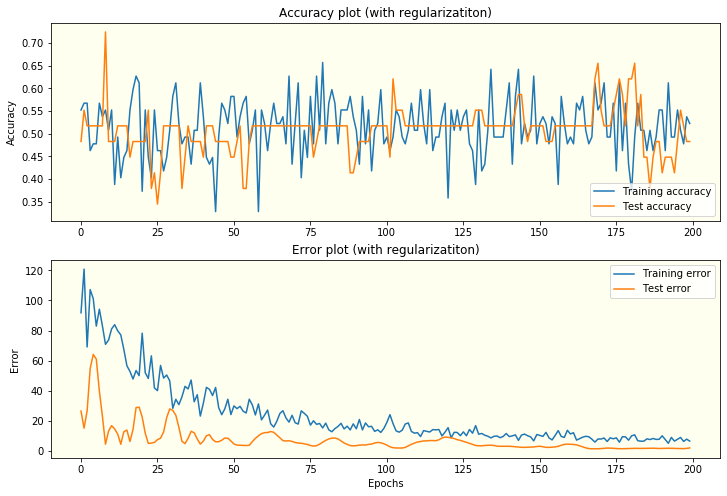

In [8]:
## 6. Plot training curves - With drop-out and L2 regularization
plot_history(history_reg, regularization_flag=True)

In [16]:
def load_mappings(json_file):
    with open(json_file, "r") as fp:
        data = json.load(fp)
        
        # Note: mfcc was converted from a numpy array to list before storing in JSON
        #  Need convert back to numpy array
        genre_mapping = np.array(data["mapping"])
        
    return genre_mapping

def predict(model, X, y):
    
    # For prediction we need 4 D so need to add the sample number as 1st dim.
    # X -> (1, 130, 13, 1) where the 1st dim is the sample size = 1
    X = X[np.newaxis, ...]
    
    # Get "predictions", which is an array of probablities [[0.37, 0.11, 0.87, ...]]
    prediction = model.predict(X)
    
    # Extract index with max. value
    predicted_index = np.argmax(prediction, axis=1)

    # Get semantaic labels (i.e. text genre labels)
    mapping = load_mappings(JSON_FILE)
    
    # Map indexes to genre labels
    expected_genre_label = mapping[y]
    predicted_genre_label = mapping[predicted_index][0]
    
    print("Expected genre: '{}'. Predicted genre: '{}'".format(expected_genre_label, predicted_genre_label))

In [22]:
import random

## 6. Predict
sample = random.randint(0,19) # Total 20 samples, so select any sample 1-20
X = X_test[sample] 
y = y_test[sample]

predict(model, X, y)

Expected genre: 'valve_abnormal'. Predicted genre: 'valve_abnormal'
